### Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# from tqdm import tqdm, trange

import fasttext
from sentence_transformers import SentenceTransformer

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

c:\Users\Kris\Documents\Studia\Semestr_VI\Sztuczna_inteligencja\Laboratorium\.venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Load jokes' ratings

In [2]:
# Load and combine (concat) ratings from 3 different files
Y = pd.concat(pd.read_excel(f"../data/jokes_ratings_{i}.xls", header=None) for i in range(1, 4))

# Take all rows and all columns starting from the second one (first one gives the number of jokes rated by that user) and convert each `99` value to `NaN` because the value `99` corresponds to "null" = "not rated"
Y = Y.iloc[:, 1:].replace(99, float("NaN"))

df_head = Y.head(10)

# Print the first 10 rows of the dataframe
print("First 10 rows of the DataFrame:")
print(df_head)

# Create LaTeX table
latex_table = df_head.to_latex(index=True, header=True, columns=[1,2,3,4,99,100], float_format="%.2f", na_rep="NaN")

# Print LaTeX table
print(latex_table)

# Print the shape of the dataframe
print("\nShape of the DataFrame:")
print(Y.shape)

First 10 rows of the DataFrame:
    1     2     3     4     5     6     7     8     9     10   ...   91   \
0 -7.82  8.79 -9.66 -8.16 -7.52 -8.50 -9.85  4.17 -8.98 -4.76  ...  2.82   
1  4.08 -0.29  6.36  4.37 -2.38 -9.66 -0.73 -5.34  8.88  9.22  ...  2.82   
2   NaN   NaN   NaN   NaN  9.03  9.27  9.03  9.27   NaN   NaN  ...   NaN   
3   NaN  8.35   NaN   NaN  1.80  8.16 -2.82  6.21   NaN  1.84  ...   NaN   
4  8.50  4.61 -4.17 -5.39  1.36  1.60  7.04  4.61 -0.44  5.73  ...  5.19   
5 -6.17 -3.54  0.44 -8.50 -7.09 -4.32 -8.69 -0.87 -6.65 -1.80  ... -3.54   
6   NaN   NaN   NaN   NaN  8.59 -9.85  7.72  8.79   NaN   NaN  ...   NaN   
7  6.84  3.16  9.17 -6.21 -8.16 -1.70  9.27  1.41 -5.19 -4.42  ...  7.23   
8 -3.79 -3.54 -9.42 -6.89 -8.74 -0.29 -5.29 -8.93 -7.86 -1.60  ...  4.37   
9  3.01  5.15  5.15  3.01  6.41  5.15  8.93  2.52  3.01  8.16  ...   NaN   

    92    93    94    95    96    97    98    99    100  
0   NaN   NaN   NaN   NaN   NaN -5.63   NaN   NaN   NaN  
1 -4.95 -0.29  

### Calculate mean rating for each joke

In [3]:
Y = Y.mean()

# Describe converted dataframe
print("DataFrame description:")
print(Y.describe())

# Print the head of the dataframe
print("\nHead of the DataFrame:")
print(Y.head())

# Print the shape of the dataframe
print("\nShape of the DataFrame:")
print(Y.shape)

DataFrame description:
count    100.000000
mean       0.702018
std        1.490444
min       -3.704541
25%       -0.416897
50%        0.996985
75%        1.793516
max        3.362593
dtype: float64

Head of the DataFrame:
1    0.901997
2    0.162989
3    0.193411
4   -1.412599
5    0.235352
dtype: float64

Shape of the DataFrame:
(100,)


### Load jokes from html files

In [4]:
jokes = []

for i in range(1, 101):
    with open(f"../data/jokes/init{i}.html", "r") as file:
        soup = BeautifulSoup(file.read(), 'html.parser')
        extracted_text = ' '.join(itertools.islice(soup.stripped_strings, 1, None))
        text_no_long_whitespaces = ' '.join(extracted_text.split())
        final_joke = text_no_long_whitespaces.replace('Q.', '').replace('A.', '')
        jokes.append(final_joke.strip())

In [5]:
print("Example jokes:")

for i, joke in enumerate(jokes[:10]):
    print(f"[{i}] : {joke}")

Example jokes:
[0] : A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer's disease". The man replies "Well,thank God I don't have cancer!"
[1] : This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked her why she was leaving him and she told him that she had heard awful things about him. "What could they possibly have said to make you move out?" "They told me that you were a pedophile." He replied, "That's an awfully big word for a ten year old."
[2] : What's 200 feet long and has 4 teeth?  The front row at a Willie Nelson Concert.
[3] : What's the difference between a man and a toilet?  A toilet doesn't follow you around after you use it.
[4] : What's O. J. Simpson's Internet address?  Slash, slash, backslash, slash, slash, escape.
[5] : Bill & Hillary are on a trip back to Arkansas. They're almost out of gas, so Bill pulls into a service station on the outskirts of town. 

## Utils

In [6]:
import os

def create_chart(train_pred: list[float], test_pred: list[float], iterations: int, chart_filename: str, embeddings: str, parameter: str):
    _, ax = plt.subplots(figsize=(10,5))
    colors = ['#f77189', '#00a88d', '#b8d200']

    ax.plot(range(iterations), train_pred, label='Train set (X_train)', color=colors[0])
    ax.plot(range(iterations), test_pred, label='Test set (X_test)', color=colors[1])
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    ax.set_xticks(range( 0, iterations + 1, int(iterations/10) ))

    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE (loss function)')
    ax.set_title(f'MSE (loss function) for training and test sets depending on the epoch | Emb. = {embeddings} | {parameter}')
    ax.legend(loc='upper right')

    folder_path = os.path.join('..', 'charts')
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    plt.savefig(f'../charts/{chart_filename}.png', dpi=300)
    plt.show()


def run_mlp_network_test(X_train, X_test, Y_train, Y_test, mlp_regressor: MLPRegressor, iterations: int, chart_filename: str, embeddings: str, parameter: str):
    train_set_predictions = []
    test_set_predictions = []

    for _ in range(iterations):
        mlp_regressor.fit(X_train, Y_train)

        # predict values for X_train set
        Y_train_pred = mlp_regressor.predict(X_train)
        train_set_predictions.append(mean_squared_error(Y_train, Y_train_pred))

        # predict values for X_test set
        Y_test_pred = mlp_regressor.predict(X_test)
        test_set_predictions.append(mean_squared_error(Y_test, Y_test_pred))
    
    create_chart(train_set_predictions, test_set_predictions, iterations, chart_filename, embeddings, parameter)

### Suppress warnings

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## MLP regression tests with Bert embeddings

In [8]:
model = SentenceTransformer('bert-base-cased')
X = model.encode(jokes)

# print embeddings shape
print(X.shape)

No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.
c:\Users\Kris\Documents\Studia\Semestr_VI\Sztuczna_inteligencja\Laboratorium\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(100, 768)


#### Default MLPRegressor

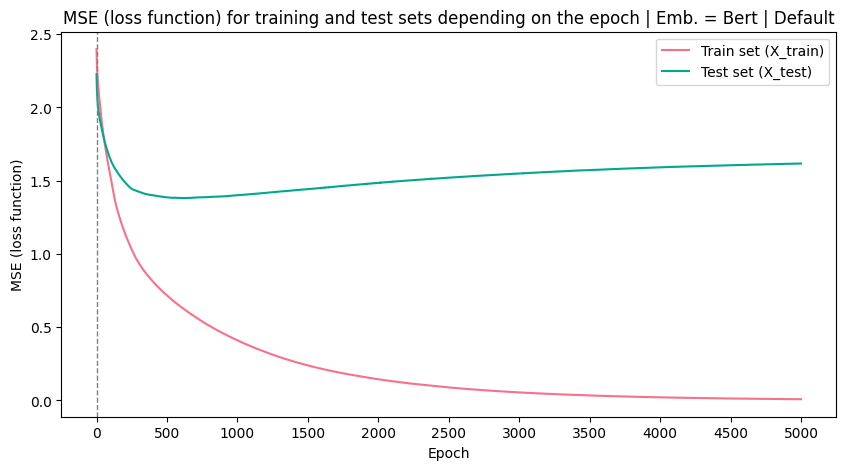

In [9]:
rng = np.random.RandomState(42)

mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', random_state=rng, warm_start=True, max_iter=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rng)
run_mlp_network_test(X_train, X_test, Y_train, Y_test, mlp, iterations=5000, chart_filename='bert_default', embeddings='Bert', parameter='Default')

#### Testing learning rate impact

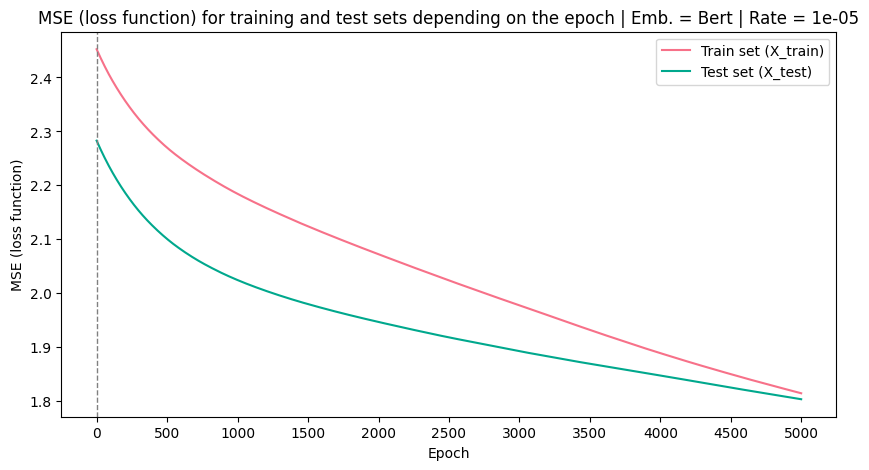

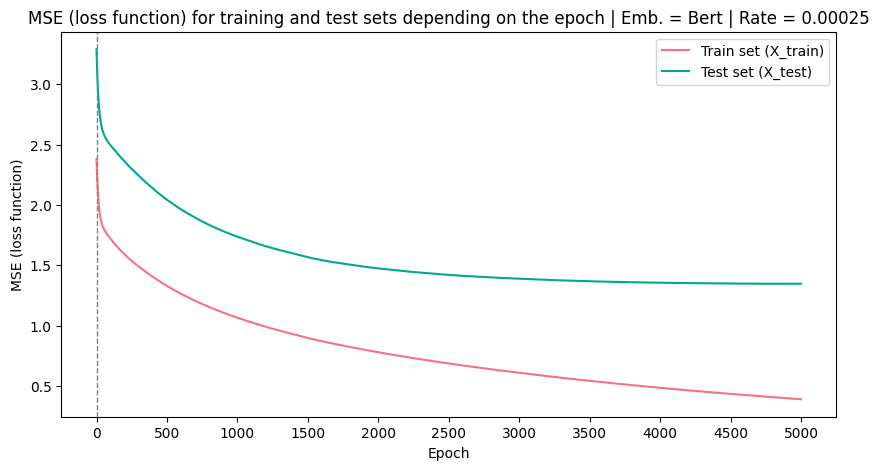

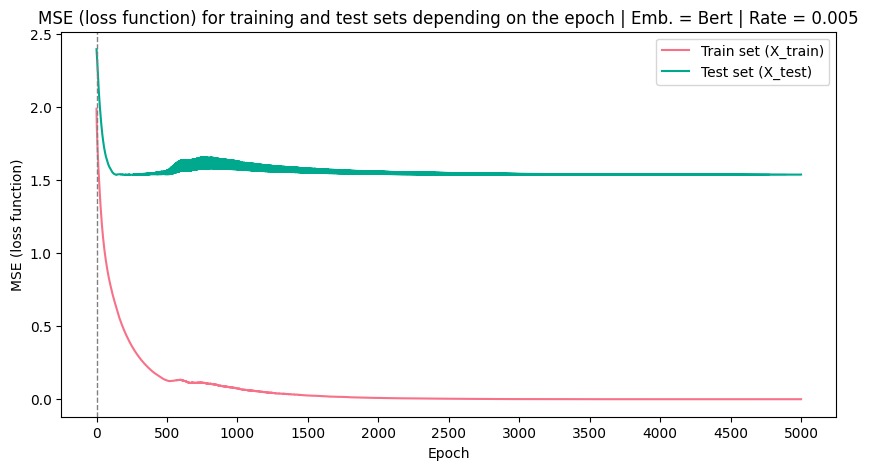

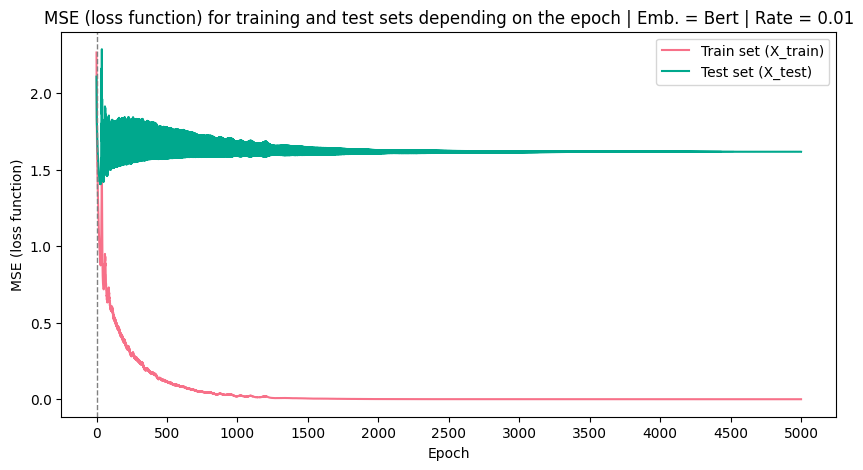

In [10]:
rng = np.random.RandomState(42)
learning_rates = [0.00001, 0.00025, 0.005, 0.01]

for rate in learning_rates:
    mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=rate, random_state=rng, warm_start=True, max_iter=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rng)
    run_mlp_network_test(X_train, X_test, Y_train, Y_test, mlp, iterations=5000, chart_filename=f'bert_rate_{str(rate).replace('.', '_')}', embeddings='Bert', parameter=f'Rate = {rate}')

#### Testing neurons count impact

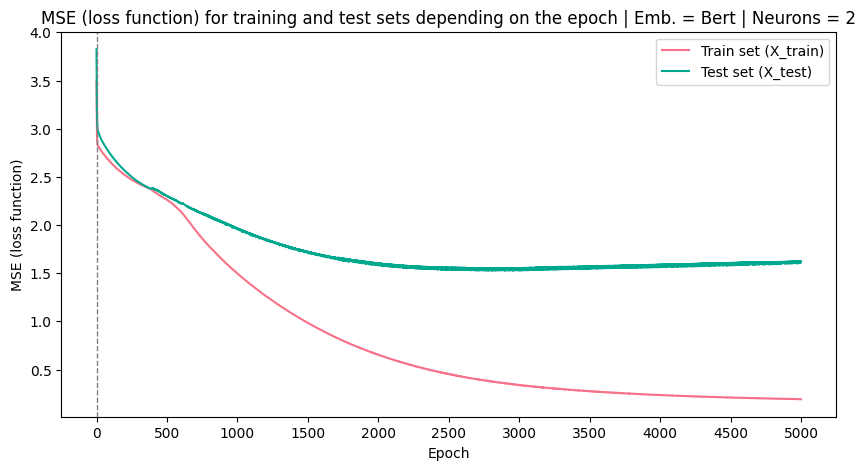

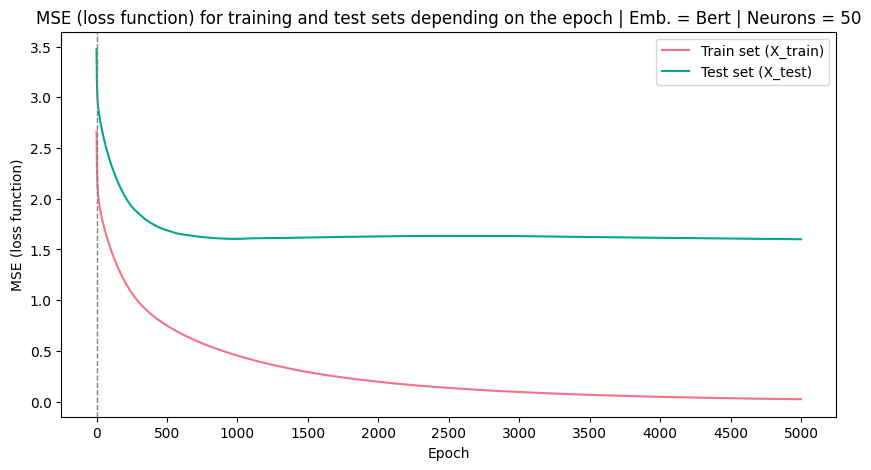

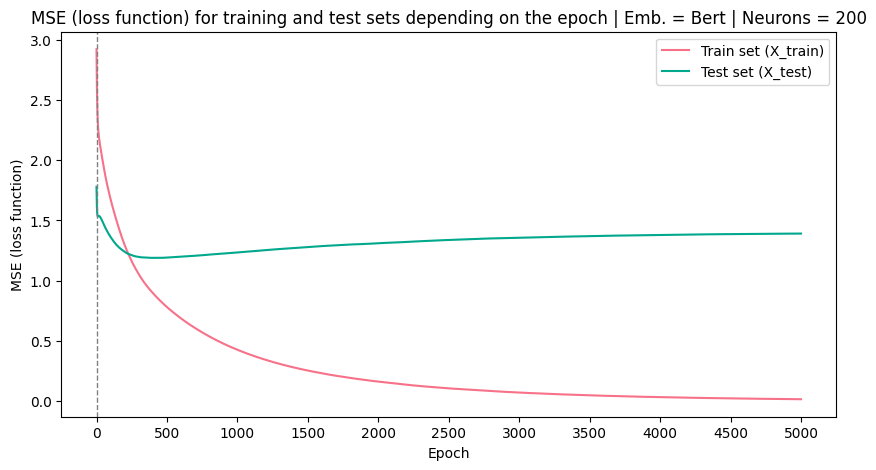

In [11]:
rng = np.random.RandomState(42)
neurons_counts = [2, 50, 200]

for count in neurons_counts:
    mlp = MLPRegressor(hidden_layer_sizes=(count,), solver='sgd', alpha=0.0, learning_rate='constant', random_state=rng, warm_start=True, max_iter=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rng)
    run_mlp_network_test(X_train, X_test, Y_train, Y_test, mlp, iterations=5000, chart_filename=f'bert_neurons_{count}', embeddings='Bert', parameter=f'Neurons = {count}')

#### Custom tests

In [12]:
rng = np.random.RandomState(42)

custom_jokes = [
    "Singing in the shower is fun until you get soap in your mouth. Then it's a soap opera.",
    "Why was the computer cold? It left its Windows open.",
    "Why was the computer cold? Because the computer left its Windows open.",
    "Why dont some couples go to the gym? Because some relationships dont work out.",
    "What is your name? James",
    "What's the best thing about Switzerland? The flag is a big plus.",
    "I went to the cinema yesterday",
    "What why where when? This, because, there, today,",
    "Why should Poland win today against Austria? Because Poland is better",
    "What do you call a fella from Dundalk with 400 girlfriends? A farmer!",
    "How do lumberjacks know how many trees they've cut down? They keep a log."
]

custom_X = model.encode(custom_jokes)

mlp = MLPRegressor(hidden_layer_sizes=(200,), solver='sgd', alpha=0.0, learning_rate='constant', random_state=rng, warm_start=True, max_iter=500)
X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.3, random_state=rng)
mlp.fit(X_train, Y_train)

predicts = mlp.predict(custom_X)

jokes_with_ratings = zip(custom_jokes, predicts)
jokes_with_ratings_sorted = sorted(jokes_with_ratings, key = lambda pair: pair[1], reverse=True)

for joke, rating in jokes_with_ratings_sorted:
    print(f"{joke} -> {rating}")
# for i in range(len(custom_jokes)):
#     print(f"{custom_jokes[i]} -> {predicts[i]}")

Why should Poland win today against Austria? Because Poland is better -> -0.2904995083808899
Why dont some couples go to the gym? Because some relationships dont work out. -> -0.3903155028820038
What do you call a fella from Dundalk with 400 girlfriends? A farmer! -> -0.8887691497802734
What's the best thing about Switzerland? The flag is a big plus. -> -1.2468342781066895
How do lumberjacks know how many trees they've cut down? They keep a log. -> -1.5986783504486084
Singing in the shower is fun until you get soap in your mouth. Then it's a soap opera. -> -1.7682883739471436
Why was the computer cold? Because the computer left its Windows open. -> -1.7963618040084839
What is your name? James -> -1.898957371711731
What why where when? This, because, there, today, -> -1.968941330909729
I went to the cinema yesterday -> -2.1294753551483154
Why was the computer cold? It left its Windows open. -> -2.3617007732391357


## MLP regression tests with FastText embeddings

In [13]:
del model, X

fasttext_path = os.path.join('generate_embeddings', 'cc.en.300.bin')
model = fasttext.load_model(fasttext_path)

X = np.array([model.get_sentence_vector(joke) for joke in jokes])

# print embeddings shape
print(X.shape)

(100, 300)


#### Default MLPRegressor

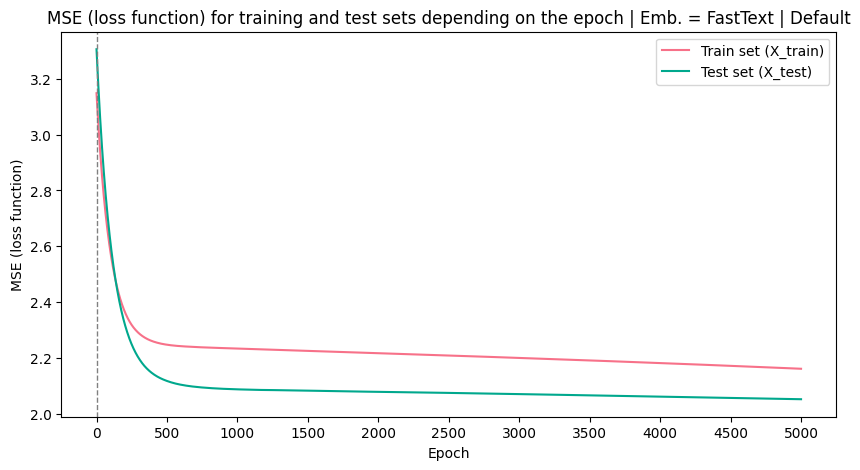

In [14]:
rng = np.random.RandomState(42)

mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', random_state=rng, warm_start=True, max_iter=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rng)
run_mlp_network_test(X_train, X_test, Y_train, Y_test, mlp, iterations=5000, chart_filename='fasttext_default', embeddings='FastText', parameter='Default')

#### Testing learning rate impact

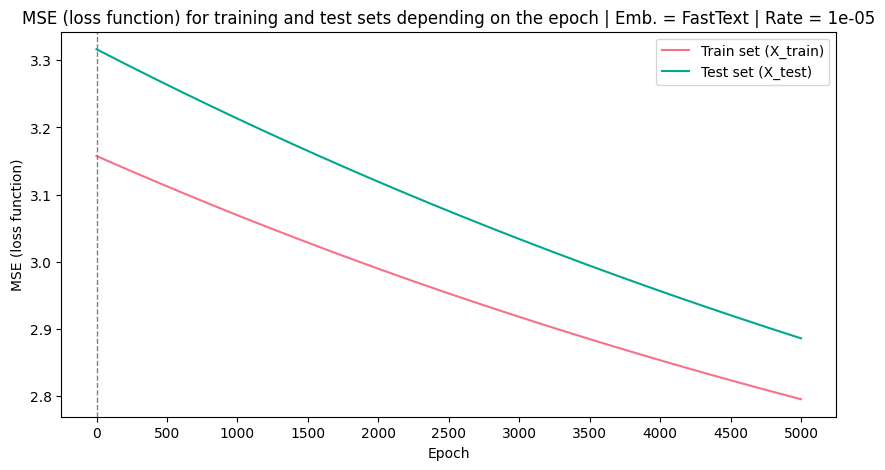

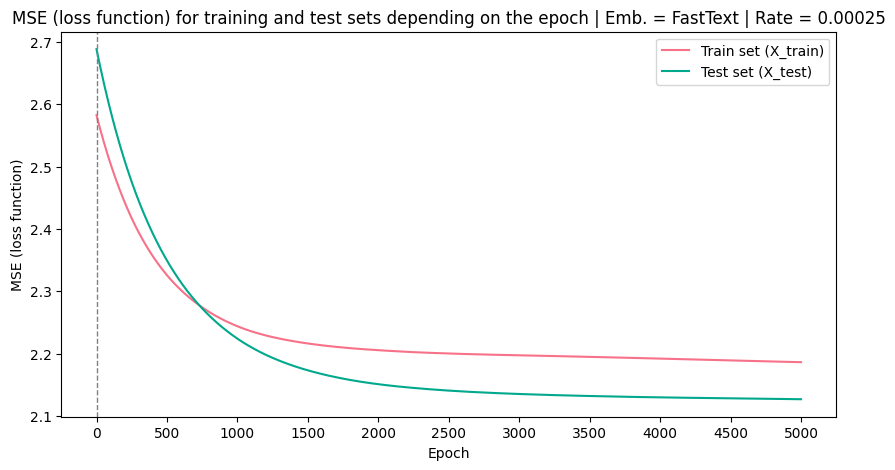

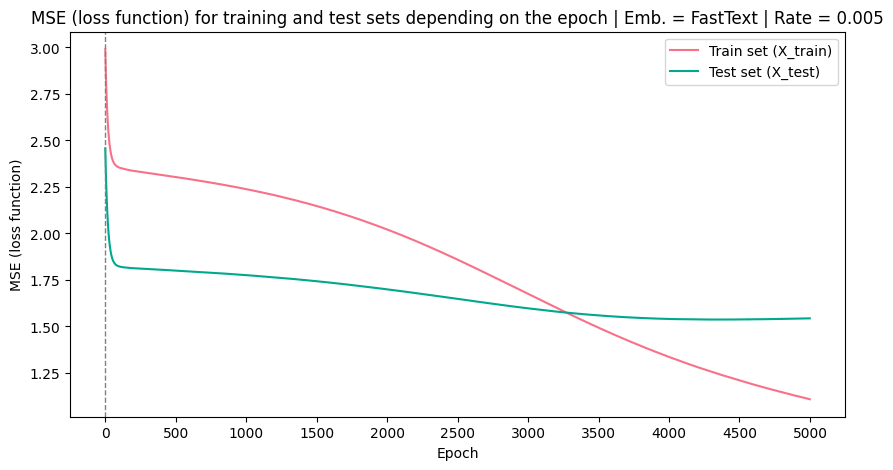

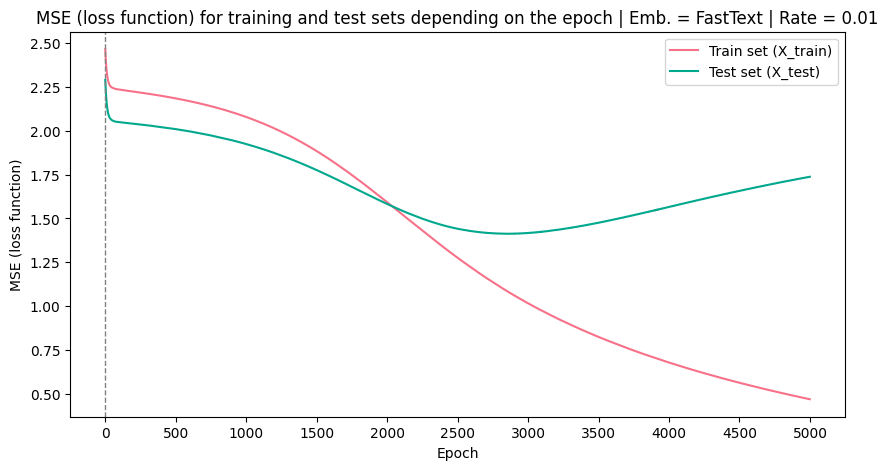

In [15]:
rng = np.random.RandomState(42)
learning_rates = [0.00001, 0.00025, 0.005, 0.01]

for rate in learning_rates:
    mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', learning_rate_init=rate, random_state=rng, warm_start=True, max_iter=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rng)
    run_mlp_network_test(X_train, X_test, Y_train, Y_test, mlp, iterations=5000, chart_filename=f'fasttext_rate_{str(rate).replace('.', '_')}', embeddings='FastText', parameter=f'Rate = {rate}')

#### Testing neurons count impact

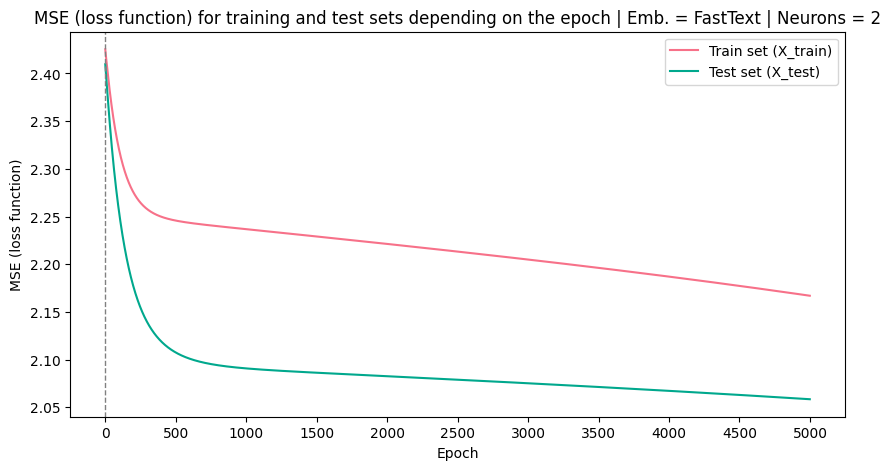

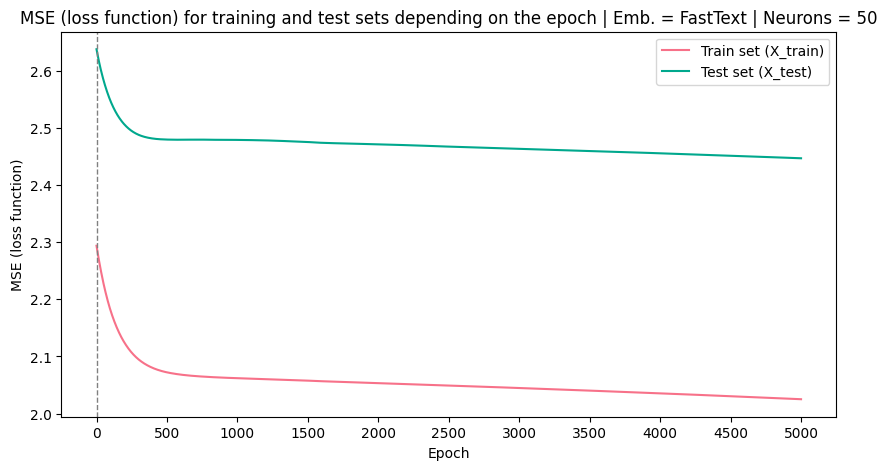

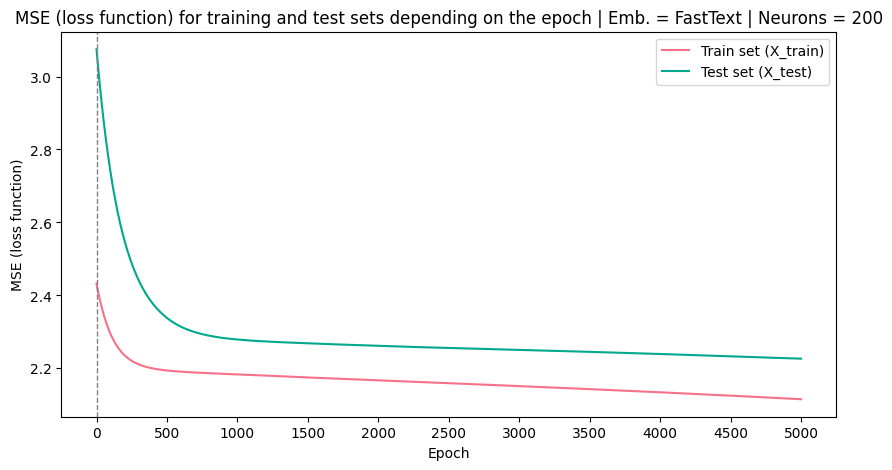

In [16]:
rng = np.random.RandomState(42)
neurons_counts = [2, 50, 200]

for count in neurons_counts:
    mlp = MLPRegressor(hidden_layer_sizes=(count,), solver='sgd', alpha=0.0, learning_rate='constant', random_state=rng, warm_start=True, max_iter=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rng)
    run_mlp_network_test(X_train, X_test, Y_train, Y_test, mlp, iterations=5000, chart_filename=f'fasttext_neurons_{count}', embeddings='FastText', parameter=f'Neurons = {count}')

In [17]:
del model, X